# Past Earth Network Emulator Meeting: Lab 3

by Alan Saul and Richard Wilkinson.

In this final lab session, we will look at doing PCA dimension reduction of high dimensional simulator output in order to emulate a climate model. We will then do a crude calibration/history-matching exercise to fit the simulator to data. We will then look briefly at using non-Gaussian likelihood functions in GPy.



## 1. Emulating the UVic climate model

UVic ESCM is an intermediate complexity model with a general circulation ocean and dynamic/thermodynamic sea-ice components coupled to a simple energy/moisture balance atmosphere. It has a dynamic vegetation and terrestrial carbon cycle model (TRIFFID) as well as an inorganic carbon cycle.

We will just consider two of the inputs to this model

Inputs: 
- Q10 = soil respiration sensitivity to temperature (carbon source) and 
- Kc = CO2 fertilization of photosynthesis (carbon sink).

and just examine the time-series of CO2 values predicted for different values of these parameters.

Output: 
- time-series of CO2 values

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy

A simple factorial design was used for Q10 and Kc here. 

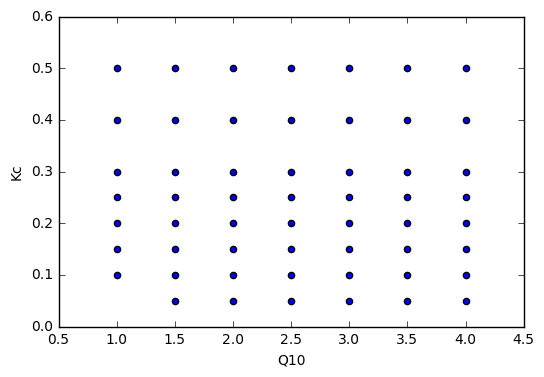

In [2]:
X = np.genfromtxt('https://raw.githubusercontent.com/rich-d-wilkinson/PEN_Labs/master/UVic_x.csv', delimiter=',', skip_header=1)
plt.scatter(X[:,0], X[:,1])
plt.xlabel('Q10')
plt.ylabel('Kc')

At each point in the design the simulator was run, giving us a time-series of CO2 values. There is one curve per simulator run here.

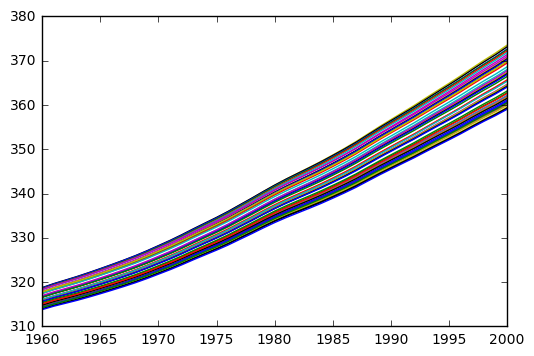

In [3]:
y = np.genfromtxt('https://raw.githubusercontent.com/rich-d-wilkinson/PEN_Labs/master/simco2.csv', delimiter=',', skip_header=1)
#y = np.genfromtxt('simco2.csv', delimiter=',', skip_header=1)
y=y.T
y=y[1:,:]
for i in range(y.shape[0]):
    plt.plot(np.arange(1960, 2001,1), y[i,:])
plt.show()

Our aim is to use the observational data, to infer what value of Q10 and Kc are realistic. Let's plot the data on top of these curves.

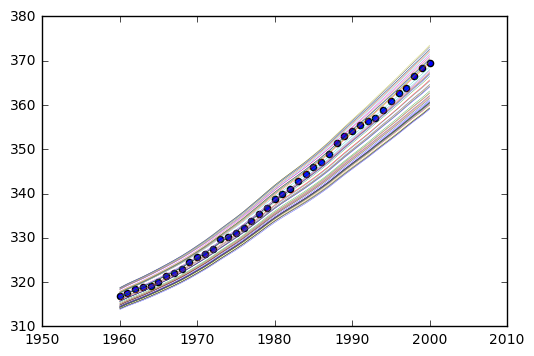

In [4]:
yobs = np.genfromtxt('https://raw.githubusercontent.com/rich-d-wilkinson/PEN_Labs/master/fieldco2.csv', delimiter=',', skip_header=1)
yobs=yobs[:,1]
for i in range(y.shape[0]):
    plt.plot(np.arange(1960, 2001,1), y[i,:], linewidth=0.2 )
plt.scatter(np.arange(1960, 2001,1), yobs)
plt.show()



The output from each simulator run is 41 different numbers. We could build a different emulator for each output, but that would be hard work. Lets instead use principal component analysis to reduce the dimension. 

There is a good implementation of PCA in sklearn that we will use here. Lets just use 2 components for now and visualise them. Note that the PCA command automatically removes the mean trend before doing the PCA. 

array([  3.42899287e+02,   1.56627624e-01])

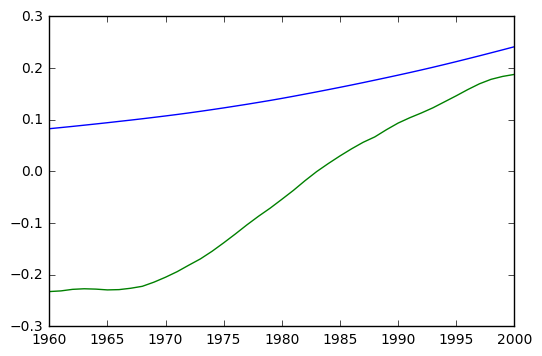

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(y)
plt.plot(np.arange(1960, 2001,1), pca.components_[0,:])
plt.plot(np.arange(1960, 2001,1), pca.components_[1,:])
pca.explained_variance_


Now let's project the simulated data onto these principal components. We can visualise the 55 simulator evaluations in this new 2d space.

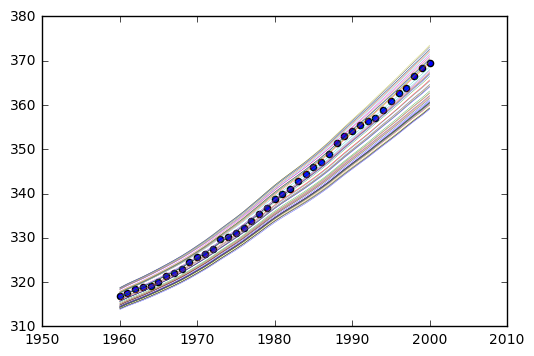

In [6]:
y_proj = pca.transform(y)
#plt.scatter(y_proj[:,0], y_proj[:,1])
y_recon = pca.inverse_transform(y_proj)
for i in range(y.shape[0]):
    plt.plot(np.arange(1960, 2001,1), y[i,:], linewidth=0.2 )
plt.scatter(np.arange(1960, 2001,1), yobs)
plt.show()




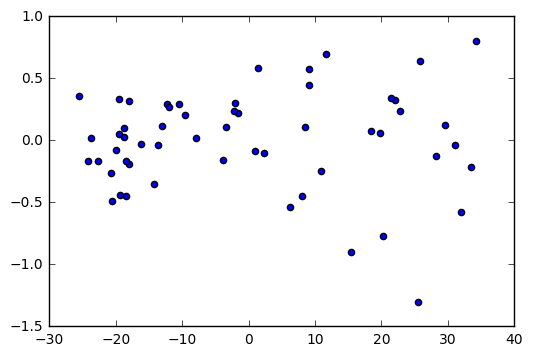

In [7]:
plt.scatter(y_proj[:,0], y_proj[:,1])

We can also project the data onto the same set of components and add this point to our plot.

array([[ 14.7633426,   4.0248833]])

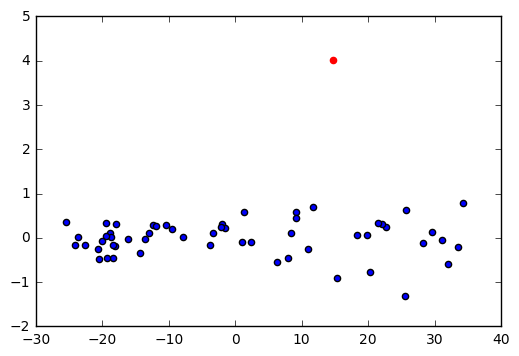

In [8]:

yobs_proj = pca.transform(yobs[None,:])
plt.scatter(y_proj[:,0], y_proj[:,1])
plt.scatter(yobs_proj[:,0], yobs_proj[:,1],color='red' )
yobs_proj

Notice that the data score on the first PC lies within the set of simulator runs, but the second PC score is a long way from the simulator runs. This could be due to model discrepancy.

Let's just focus on the first PC. We'll build a simple emulator to predict this component.

In [9]:
k1 =GPy.kern.RBF(2, ARD=True)
m1 = GPy.models.GPRegression(X, y_proj[:,0].reshape((X.shape[0],1)), k1)
m1.optimize_restarts(10)
print(m1)


Optimization restart 1/10, f = 88.9824538249068
Optimization restart 2/10, f = 88.98245388505461
Optimization restart 3/10, f = 88.98245382492078
Optimization restart 4/10, f = 88.98245382884068
Optimization restart 5/10, f = 88.98245382755294
Optimization restart 6/10, f = 88.98245382943632
Optimization restart 7/10, f = 88.98245384509147
Optimization restart 8/10, f = 88.98245382490097
Optimization restart 9/10, f = 88.98245382906205
Optimization restart 10/10, f = 88.98245382497882

Name : GP regression
Objective : 88.98245382490097
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   475.534577146  |      +ve      |        
  rbf.lengthscale          |            (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.509079838266  |      +ve      |        


In [10]:
Xp1, Xp2 = np.meshgrid(np.linspace(1,4,100), np.linspace(0.0, 0.6, 50))
Xp = np.hstack((Xp1.flatten()[:, None], Xp2.flatten()[:, None]))

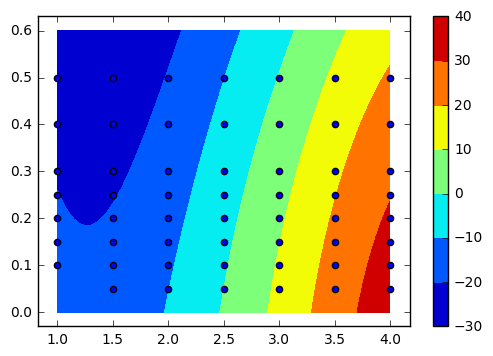

In [11]:
mup, Vp = m1.predict_noiseless(Xp)
plt.contourf(Xp1, Xp2, mup.reshape(50, 100))
plt.colorbar()
plt.scatter(X[:,0], X[:,1])


In [12]:
Xp = np.meshgrid

Let's now try to do a simple history match. We'll use a simple history match completely ignoring the issue of discrepancy (which is not recommended!). We'll do the history match in principal component space, which isn't recommended either.

We'll use a uniform prior for Q10 and Kc: 
$$Q_{10}\sim U[1,4] \qquad K_c \sim U[0.0, 0.6]$$

We'll do the calibration using an approximate Bayesian computation (ABC) type approach, which is a generic approach which includes history matching as a special case. We will 

- simulate a large number of sample parameter values from the prior distribution
- for each parameter value, we'll use the emulator to predict what the simulator PC1 score would be
- We'll then accept those parameters that give PC1 scores that are close to the PC1 score we found for the data.

In [13]:
Q10 = np.random.rand(1000,1)*3+1
Kc = np.random.rand(1000,1)*0.6+0.0
Xpred = np.concatenate((Q10, Kc), axis=1)

In [14]:
mu, V = m1.predict(Xpred)



We'll use a simple implausibility type measure here to rule parameter sets in or out here. Note again that we're just dividing by the variance of the emulator, completely ignoring measurement error and simulator discrepancy. We use a 3-sigma rule to determine the cut-off.

(0.0, 0.6)

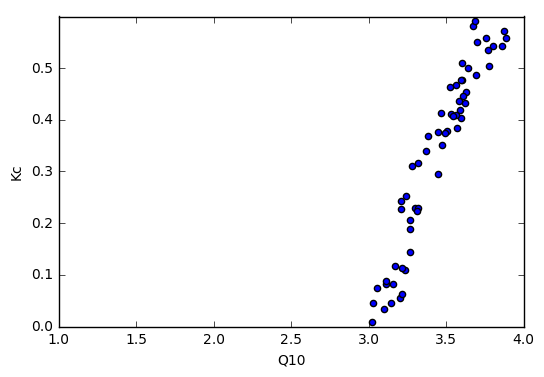

In [15]:
Implausibility = (mu-yobs_proj[0,0])**2/(V)
keep = Implausibility<=3**2
plt.scatter(Xpred[keep.flatten(),0], Xpred[keep.flatten(),1])
plt.xlabel('Q10')
plt.ylabel('Kc')
axes=plt.gca()
axes.set_xlim(1,4)
axes.set_ylim(0.0,0.6)


### Exercise
Compare your history match with the contour plot of the emulator above. Does it make sense?

Try building an emulator for PC2 and then calibrating to both PC scores.
- What is the danger here?
- Try adding a simulator discrepancy variance of 3. How does that change your history match?
- Repeat this with a subsample of the training set (n=20 simulator runs for example). How does this change the resulting history match.

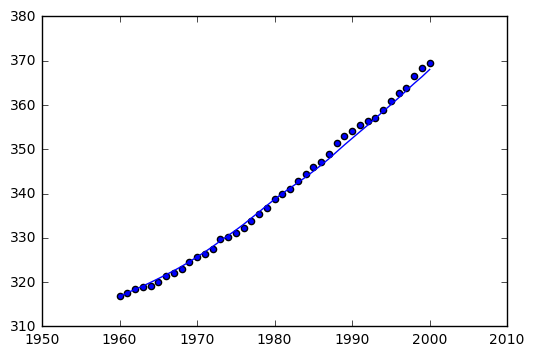

In [16]:
X[31,]
yobs = np.genfromtxt('https://raw.githubusercontent.com/rich-d-wilkinson/PEN_Labs/master/fieldco2.csv', delimiter=',', skip_header=1)
yobs=yobs[:,1]

plt.plot(np.arange(1960, 2001,1), y[31,:], linewidth=1 )
plt.scatter(np.arange(1960, 2001,1), yobs)
plt.show()




If you want to see a more detailed analysis of this dataset, and an introduction to the use of PCA emulators, see

[Wilkinson, R. D. (2010). Bayesian calibration of expensive multivariate computer experiments. In L. T. Biegler, G. Biros, O. Ghattas, M. Heinkenschloss, D. Keyes, B. K. Mallick, … Y. Marzouk (Eds.), Large-scale inverse problems and quantification of uncertainty. John Wiley and Sons](https://rich-d-wilkinson.github.io/docs/papers/WilkinsonInverseChapter.pdf).

A complex example where we are emulating outputs which are spatial maps of the LOVECLIM simulator is available in

[Bounceur, N., Crucifix, M., & Wilkinson. (2015). Global sensitivity analysis of the climate vegetation system to astronomical forcing: an emulator-based approach. Earth Syst. Dynam. Discuss, 6, 205–224.](https://rich-d-wilkinson.github.io/docs/papers/WilkinsonInverseChapter.pdf)

We can also do dimension reduction on the inputs. Emulating from spatial maps to spatial maps is done in 

[Crevillén-García, D., Wilkinson, R. D., and A. A. Shah, & Power, H. (2017). Gaussian Process Modelling for Uncertainty Quantification in Convectively-Enhanced Dissolution Processes in Porous Media. Advances In Water Resources, 99, 1–14.](https://rich-d-wilkinson.github.io/docs/papers/Crevillen_etal2016.pdf)

and

[Holden, P. B., Edwards, N. R., Garthwaite, P. H., & Wilkinson. (2015). Emulation and interpretation of high-dimensional climate model outputs. Journal Of Applied Statistics, 42, 2038–2055.](https://rich-d-wilkinson.github.io/docs/papers/Holden_etal2015.pdf)

# 2. Non-Gaussian likelihoods

Here, we will consider data on the pace (mins/km) of the winner in the mens' olympic marathon. 

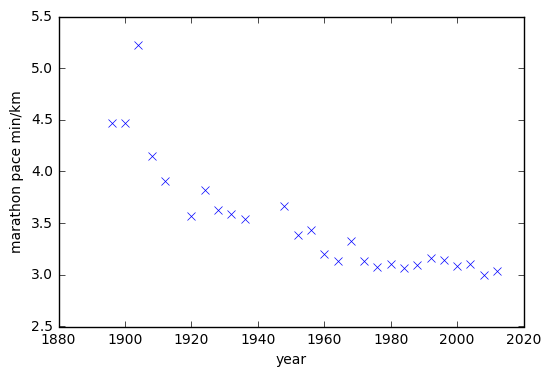

In [17]:
# Download the marathon data from yesterday and plot
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']

plt.plot(X, Y, 'bx')
plt.xlabel('year')
plt.ylabel('marathon pace min/km')



Note that there is what looks like an outlier in 1904. Fitting a GP with a Gaussian likelihood might cause trouble here, as it is likely to be heavily influenced by this outlier. 
We'll  see if we can deal with that outlier by considering a non-Gaussian likelihood. Noise sampled from a Student-t density is heavier tailed than that sampled from a Gaussian. However, it cannot be trivially assimilated into Gaussian processes as the Bayesian updates we use to find the posterior cannot now be used.


Instead we have to use one of the approximate methods. Lets use a Student-T distribution that has heavy tails to allow for the outliers without drastically effecting the posterior mean of the GP. We will use a Laplace approximation to fit the GP the model. 



In [18]:
GPy.likelihoods.StudentT?

### Laplace

 /Users/pmzrdw/GPy/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 0.000476202277713611, iteration: 30 out of max 30
 /Users/pmzrdw/GPy/GPy/inference/latent_function_inference/laplace.py:229: UserWarning:f_hat now fine again. difference: 3.999971140800085e-05, iteration: 11 out of max 30


gp.,value,constraints,priors
sum.rbf.variance,0.276023897238,+ve,
sum.rbf.lengthscale,18.4860718934,+ve,
sum.bias.variance,5.9828765131,+ve,
Student_T.t_scale2,0.00486688115521,+ve,
Student_T.deg_free,1.76641264418,+ve,


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


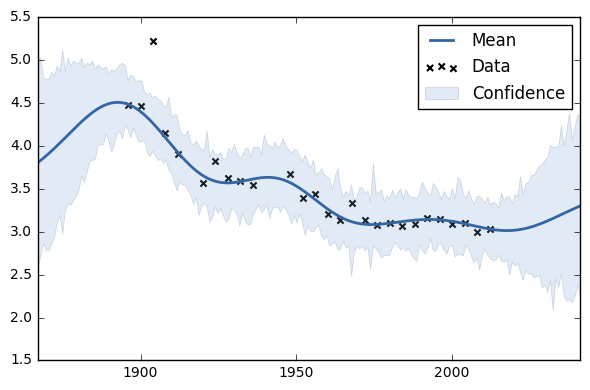

In [19]:
t_distribution = GPy.likelihoods.StudentT(deg_free=5.0, sigma2=2.0)
laplace = GPy.inference.latent_function_inference.Laplace()

kern = GPy.kern.RBF(1, lengthscale=5) + GPy.kern.Bias(1, variance=4.0)
m_stut = GPy.core.GP(X, Y, kernel=kern, inference_method=laplace, likelihood=t_distribution)

m_stut.optimize()
m_stut.plot(plot_density=False)

m_stut

### Exercise: 
Check your model fits well. Can you make a prediction (with confidence interval) for what will happen in 2020? 

Try fitting a model with a Gaussian likelihood. How does the fit differ?

There are other approximate inference methods used in GPy. Use the online documentation to find out about EP and variational approaches.